A multipurpose notebook for requesting all types of historical data. It can request new data or update existing DFs without the need to re-inputting parameters. It will request data based on inputted (or deciphered from the filename, for updates) parameters such as bar_size, duration, include IV data, use regular trading hours, etc.

In [2]:
import matplotlib.pyplot as plt
import pandas_market_calendars as pmc
import scipy.stats as stats
%matplotlib inline
import pandas as pd
import numpy as np
import math
import re
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')
pd.set_option("display.max_rows", 50, "display.max_columns", 10)
from ib_insync import *
util.startLoop()

In [2]:
PORT = 4002  # or 7497
ib = IB()
ib.connect('127.0.0.1', PORT, clientId=2)

<IB connected to 127.0.0.1:4002 clientId=2>

In [5]:
is_update = False

In [6]:
if is_update:
    recalculate_columns = True  # only for 1 day bars where customs columns are calculated.
    file_name = '1day_spx_max_iv_rth.pkl'  # starts after ..dfs/ and should include .pkl. Only used for updates
else:
    # below is only used for original requests. It is irrelevant for updates.
    underlying_symbol = 'SPX'
    underlying_type = 'IND'  # STK or IND
    underlying_exchange = 'CBOE' or 'SMART'
    get_iv_data  = True  # !! This often reduces rows because IV data typically doesn't go as far back as price data!
    use_vix = True  # only for SPX, if grabbing IV data for SPX, use the VIX index itself.
    duration = 'MAX'  # can be: # S, # D, # W, # M, # Y or 'MAX' for all available data
    bar_size = '1 min'  # can be: # min(s), # hr, # day, etc.
    use_rth = True  # False is useful for analyzing massive price swings outside RTH.

In [4]:
# load all the helper functions by running this cell

def get_earliest_timestamp(underlying, vix=None) -> datetime:
    # grab earliest stamp using:
    # https://interactivebrokers.github.io/tws-api/head_timestamp.html#reqHeadTimeStamp
    trade_earliest = ib.reqHeadTimeStamp(underlying, 'TRADES', use_rth)
    if underlying_symbol == 'SPX' and get_iv_data and use_vix:
        iv_earliest = ib.reqHeadTimeStamp(vix, 'TRADES', use_rth)
    elif get_iv_data:
        iv_earliest = ib.reqHeadTimeStamp(underlying, 'OPTION_IMPLIED_VOLATILITY', use_rth)
    else:
        return trade_earliest
    return max(trade_earliest, iv_earliest)


def calc_duration(earliest_timestamp) -> str:
    # calculate a duration in years for which data will be requested based on the earliest timestamp
    current = datetime.now().year
    earliest = earliest_timestamp.year
    return f'{(current - earliest) + 1} Y'


def add_back_space(string):
    return re.sub(r"([0-9]+(\.[0-9]+)?)",r" \1 ", string).strip()


def decipher_filename(filename) -> tuple:
    if filename == '':
        print('Enter a valid filename.')
    filename = filename.split('.')[0]
    output = filename.split('_')
    output_length = len(output)
    bar_size = add_back_space(output[0])
    underlying_symbol = output[1].upper()
    duration = add_back_space(output[2])
    use_vix = False
    if output_length >= 4:
        if output[3] == 'iv':
            get_iv_data = True
            if underlying_symbol in indices:
                use_vix = True
        else:
            get_iv_data = False
    else:
        get_iv_data = False
    if output_length >= 5:
        if output[4] == 'rth':
            use_rth = True
        else:
            use_rth = False
    else:
        use_rth = False
    if underlying_symbol in indices:
        underlying_type = 'IND'
        underlying_exchange = 'CBOE'
    else:
        underlying_type = 'STK'
        underlying_exchange = 'SMART'

    return (bar_size, underlying_symbol, underlying_type,
            underlying_exchange, duration, get_iv_data, use_rth, use_vix)


def get_missing_days(existing_df):
    try:
        last_known_date = existing_df.iloc[-1]['date'].date()
    except AttributeError:
        last_known_date = existing_df.iloc[-1]['date']
    today = datetime.now().date()
    days_missing = (today - last_known_date).days  # total days, not trading days
    today = str(today).replace('-', '')
    end_date_time = f"{today} 24:00:00 EST"
    days_missing = f"{days_missing} D"
    print(f'last date in df: {last_known_date}, today: {today} ({days_missing} days)')
    return days_missing, end_date_time


def recalculate_column_values(df):
    df['prev_close'] = df['close'].shift(1)
    df['iv_prev_close'] = df['iv_close'].shift(1)

    # open-close movement
    df['open_close'] = (df['close'] - df['open']) / df['open']  # former 'movement'; intraday movement
    df['close_close'] = (df['prev_close'] - df['close']) / df['prev_close']  # interday movement
    df['close_open'] = (df['open'] - df['prev_close']) / df['prev_close']  # overnight movement

    df['iv_open_close'] = (df['iv_close'] - df['iv_open']) / df['iv_open']  # former 'movement'; intraday movement
    df['iv_close_close'] = (df['iv_prev_close'] - df['iv_close']) / df['iv_prev_close']  # interday movement
    df['iv_close_open'] = (df['iv_open'] - df['iv_prev_close']) / df['iv_prev_close']  # overnight movement

    # realized vol taken from this formula: https://www.realvol.com/VolFormula.htm
    df['real_vol'] = np.sqrt(252 * np.log(df['open'] / df['close']) ** 2)
    df['previous_vol'] = df['real_vol'].shift(1)
    df['max_vol'] = np.sqrt(252 * np.log(df['high'] / df['low']) ** 2)

    df['max_up'] = (df['high'] - df['open']) / df['open']
    df['max_down'] = (df['low'] - df['open']) / df['open']

    df['peak_move'] = (((df['max_up'] > df['max_down'].abs()) * df['max_up']) + 
                       ((df['max_up'] <= df['max_down'].abs()) * df['max_down']))

    df['day'] = df['date'].astype('datetime64[ns]').dt.dayofweek
    return df

def show(bar_size, underlying_symbol, underlying_type, underlying_exchange,
         duration, get_iv_data, use_rth, use_vix, end_date_time=False, use_date_df=False):
    print('----------------------------------')
    print(f'bar_size:             {bar_size}')
    print(f'underlying_symbol:    {underlying_symbol}')
    print(f'underlying_type:      {underlying_type}')
    print(f'underlying_exchange:  {underlying_exchange}')
    print(f'duration:             {duration}')
    print(f'get_iv_data:          {get_iv_data}')
    print(f'use_rth:              {use_rth}')
    print(f'use_vix:              {use_vix}')
    print(f'end_date_time:        {end_date_time}')
    print(f'use_date_df:          {use_date_df}')
    print('----------------------------------')

In [66]:
# Flag to either update a df to True to ignore all flags below and instead decipher from the filename
# set the parameters here and then just run all the below cells sequentially.
indices = {'SPX', 'VIX'}

if is_update:
    existing_df = pd.read_pickle(f'../../dfs/{file_name}')
    existing_df.info()
    parameters = decipher_filename(file_name)
    bar_size = parameters[0]
    underlying_symbol = parameters[1]
    underlying_type = parameters[2]
    underlying_exchange = parameters[3]
    duration = parameters[4]
    get_iv_data = parameters[5]
    use_rth = parameters[6]
    use_vix = parameters[7]
    duration, end_date_time = get_missing_days(existing_df)
    if 'min' in bar_size or 'hr' in bar_size:
        use_date_df = True
    else:
        use_date_df = False
    show(bar_size, underlying_symbol, underlying_type, underlying_exchange,
         duration, get_iv_data, use_rth, use_vix, end_date_time, use_date_df)
else:
    show(bar_size, underlying_symbol, underlying_type, underlying_exchange,
         duration, get_iv_data, use_rth, use_vix)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4096 entries, 0 to 4095
Data columns (total 24 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   date            4096 non-null   object 
 1   open            4096 non-null   float64
 2   high            4096 non-null   float64
 3   low             4096 non-null   float64
 4   close           4096 non-null   float64
 5   iv_open         4096 non-null   float64
 6   iv_high         4096 non-null   float64
 7   iv_low          4096 non-null   float64
 8   iv_close        4096 non-null   float64
 9   prev_close      4095 non-null   float64
 10  iv_prev_close   4095 non-null   float64
 11  open_close      4096 non-null   float64
 12  close_close     4095 non-null   float64
 13  close_open      4095 non-null   float64
 14  iv_open_close   4096 non-null   float64
 15  iv_close_close  4095 non-null   float64
 16  iv_close_open   4095 non-null   float64
 17  real_vol        4096 non-null   f

In [67]:
# create the underlying contract objects based on the above inputs
if underlying_type == 'STK':
    underlying = Stock(underlying_symbol, underlying_exchange, 'USD')
elif underlying_type == 'IND':
    underlying = Index(underlying_symbol, underlying_exchange)
    if underlying_symbol == 'SPX' and get_iv_data and use_vix:
        vix = Index('VIX', 'CBOE')
else:
    print("ERROR: INVALID INPUT(S)!")

In [62]:
if not is_update:
    today = str(datetime.now().date()).replace('-', '')
    end_date_time = f"{today} 24:00:00 EST"

    stripped_duration = duration.replace(' ', '')  # max is unchanged, which is as intended.
    stripped_barsize = bar_size.replace(' ', '')
    iv = '_iv' if get_iv_data else ''
    rth = '_rth' if use_rth else '_nonrth'

    if duration == 'MAX':
        if bar_size == '1 min':
            print("WARNING: MAX DURATION WITH 1 MIN DATA DETECTED. THIS MAY BE TOO MANY DATA TO RETRIEVE!")
        earliest_timestamp = get_earliest_timestamp()
        duration = calc_duration(earliest_timestamp)

    file_name = f'{stripped_barsize}_{underlying_symbol}_{stripped_duration}{iv}{rth}.pkl'.lower()

In [63]:
# pull 1 D bars to get the valid trading days.
if use_date_df:
    bars = ib.reqHistoricalData(underlying, endDateTime=end_date_time, durationStr=duration,
                                barSizeSetting='1 day',whatToShow='TRADES', useRTH=use_rth)
    ib.sleep(1)
    date_df = pd.DataFrame(bars)
    print(date_df)

In [68]:
"""
request the actual underlying data, then, if getting iv data, request that as well.
"""
if use_date_df:
    price_bars = []
    for date in date_df['date']:
        date = str(date).replace('-', '')
        date = f"{date} 24:00:00 EST"
        bars = ib.reqHistoricalData(underlying, endDateTime=date, durationStr='1 D',
                                    barSizeSetting=bar_size ,whatToShow='TRADES', useRTH=use_rth)
        ib.sleep(5)  # might need to increase this to 5s or 15s to avoid exceeding rate limit
        price_bars.append(bars)

    price_df = pd.DataFrame(*price_bars)
    price_df.drop(['volume', 'average', 'barCount'], axis=1, inplace=True)
    print(price_df)

    if get_iv_data:
        print('-------------------')
        # automatically run this here to grab both in one cell
        if underlying_symbol == 'SPX' and get_iv_data and use_vix:
            underlying = vix
            what_to_show = 'TRADES'
            scale_down = True
        else:
            # underlying is unchanged from above, just grab IV using what_to_show below
            what_to_show = 'OPTION_IMPLIED_VOLATILITY'
            scale_down = False
        iv_bars = []
        for date in date_df['date']:
            date = str(date).replace('-', '')
            date = f"{date} 24:00:00 EST"
            bars = ib.reqHistoricalData(underlying, endDateTime=date, durationStr='1 D',
                                        barSizeSetting=bar_size ,whatToShow=what_to_show,
                                        useRTH=use_rth)
            ib.sleep(5)
            iv_bars.append(bars)

        iv_df = pd.DataFrame(*iv_bars)
        iv_df.drop(['volume', 'average', 'barCount'], axis=1, inplace=True)
        if scale_down:
            # VIX data are on a /100 basis. OPTION_IMPLIED_VOLATILITY is decimal. Scale VIX down to match:
            iv_df['open'] /= 100
            iv_df['high'] /= 100
            iv_df['low'] /= 100
            iv_df['close'] /= 100
        print(iv_df)
else:
    price_bars = ib.reqHistoricalData(underlying, endDateTime=end_date_time, durationStr=duration,
                                      barSizeSetting=bar_size ,whatToShow='TRADES', useRTH=use_rth)
    ib.sleep(5)
    price_df = pd.DataFrame(price_bars)
    price_df.drop(['volume', 'average', 'barCount'], axis=1, inplace=True)
    print(price_df)
    if get_iv_data:
        print('-------------------')
        if underlying_symbol == 'SPX' and get_iv_data and use_vix:
            underlying = vix
            what_to_show = 'TRADES'
            scale_down = True
        else:
            what_to_show = 'OPTION_IMPLIED_VOLATILITY'
            scale_down = False
        iv_bars = ib.reqHistoricalData(underlying, endDateTime=end_date_time, durationStr=duration,
                                       barSizeSetting=bar_size ,whatToShow=what_to_show, useRTH=use_rth)
        ib.sleep(5)
        iv_df = pd.DataFrame(iv_bars)
        iv_df.drop(['volume', 'average', 'barCount'], axis=1, inplace=True)
        if scale_down:
            iv_df['open'] /= 100
            iv_df['high'] /= 100
            iv_df['low'] /= 100
            iv_df['close'] /= 100
        print(iv_df)

          date     open     high      low    close
0   2022-01-25  4366.64  4411.01  4287.11  4356.45
1   2022-01-26  4408.43  4453.23  4304.80  4349.93
2   2022-01-27  4380.58  4428.74  4309.50  4326.51
3   2022-01-28  4336.19  4432.72  4292.46  4431.85
4   2022-01-31  4431.79  4516.89  4414.02  4515.55
5   2022-02-01  4519.57  4550.49  4483.53  4546.54
6   2022-02-02  4566.39  4595.31  4544.32  4589.38
7   2022-02-03  4535.41  4542.88  4470.39  4477.44
8   2022-02-04  4482.79  4539.66  4451.50  4500.53
9   2022-02-07  4505.75  4521.86  4471.47  4483.87
10  2022-02-08  4480.02  4531.32  4465.40  4521.54
11  2022-02-09  4547.00  4590.03  4547.00  4587.18
12  2022-02-10  4553.24  4588.92  4484.31  4504.08
13  2022-02-11  4506.27  4526.33  4401.41  4418.64
14  2022-02-14  4412.61  4426.22  4364.84  4401.67
15  2022-02-15  4429.28  4472.77  4429.28  4471.07
16  2022-02-16  4455.75  4489.55  4429.68  4475.01
17  2022-02-17  4456.06  4456.06  4373.81  4380.26
18  2022-02-18  4384.57  4394.6

In [70]:
print(len(price_df))
if get_iv_data:
    # rename columns to avoid issues when merging the dfs below
    iv_df.rename(columns={"open": "iv_open", "high": "iv_high", "low": "iv_low", "close": "iv_close"}, inplace=True)
    print(len(iv_df))

19
19


In [71]:
print(price_df)
print(iv_df)

          date     open     high      low    close
0   2022-01-25  4366.64  4411.01  4287.11  4356.45
1   2022-01-26  4408.43  4453.23  4304.80  4349.93
2   2022-01-27  4380.58  4428.74  4309.50  4326.51
3   2022-01-28  4336.19  4432.72  4292.46  4431.85
4   2022-01-31  4431.79  4516.89  4414.02  4515.55
5   2022-02-01  4519.57  4550.49  4483.53  4546.54
6   2022-02-02  4566.39  4595.31  4544.32  4589.38
7   2022-02-03  4535.41  4542.88  4470.39  4477.44
8   2022-02-04  4482.79  4539.66  4451.50  4500.53
9   2022-02-07  4505.75  4521.86  4471.47  4483.87
10  2022-02-08  4480.02  4531.32  4465.40  4521.54
11  2022-02-09  4547.00  4590.03  4547.00  4587.18
12  2022-02-10  4553.24  4588.92  4484.31  4504.08
13  2022-02-11  4506.27  4526.33  4401.41  4418.64
14  2022-02-14  4412.61  4426.22  4364.84  4401.67
15  2022-02-15  4429.28  4472.77  4429.28  4471.07
16  2022-02-16  4455.75  4489.55  4429.68  4475.01
17  2022-02-17  4456.06  4456.06  4373.81  4380.26
18  2022-02-18  4384.57  4394.6

In [72]:
# merge the two DFs and drop duplicate rows
if get_iv_data:
    new_df = pd.merge(price_df, iv_df, on='date')
else:
    new_df = price_df
if is_update:
    df = existing_df.append(new_df)
    df.reset_index(inplace=True, drop=True)
    df.drop_duplicates(subset=['date'], inplace=True)
else:
    df = new_df
if recalculate_columns:
    df = recalculate_column_values(df)
print(df)

            date     open     high      low    close  ...   max_vol    max_up  \
0     2005-10-03  1230.03  1233.35  1225.12  1226.95  ...  2.098936  0.002699   
1     2005-10-04  1227.19  1229.87  1214.08  1214.36  ...  4.050964  0.002184   
2     2005-10-05  1214.16  1214.28  1196.29  1196.29  ...  4.679312  0.000099   
3     2005-10-06  1196.68  1202.09  1181.89  1191.16  ...  5.312779  0.004521   
4     2005-10-07  1193.89  1199.76  1191.45  1196.17  ...  2.178952  0.004917   
...          ...      ...      ...      ...      ...  ...       ...       ...   
4110  2022-02-14  4412.61  4426.22  4364.84  4401.67  ...  4.377793  0.003084   
4111  2022-02-15  4429.28  4472.77  4429.28  4471.07  ...  3.063130  0.009819   
4112  2022-02-16  4455.75  4489.55  4429.68  4475.01  ...  4.208729  0.007586   
4113  2022-02-17  4456.06  4456.06  4373.81  4380.26  ...  5.840590  0.000000   
4114  2022-02-18  4384.57  4394.60  4327.22  4348.87  ...  4.843899  0.002288   

      max_down  peak_move  

In [73]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4109 entries, 0 to 4114
Data columns (total 24 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   date            4109 non-null   object 
 1   open            4109 non-null   float64
 2   high            4109 non-null   float64
 3   low             4109 non-null   float64
 4   close           4109 non-null   float64
 5   iv_open         4109 non-null   float64
 6   iv_high         4109 non-null   float64
 7   iv_low          4109 non-null   float64
 8   iv_close        4109 non-null   float64
 9   prev_close      4108 non-null   float64
 10  iv_prev_close   4108 non-null   float64
 11  open_close      4109 non-null   float64
 12  close_close     4108 non-null   float64
 13  close_open      4108 non-null   float64
 14  iv_open_close   4109 non-null   float64
 15  iv_close_close  4108 non-null   float64
 16  iv_close_open   4108 non-null   float64
 17  real_vol        4109 non-null   f

<AxesSubplot:xlabel='date'>

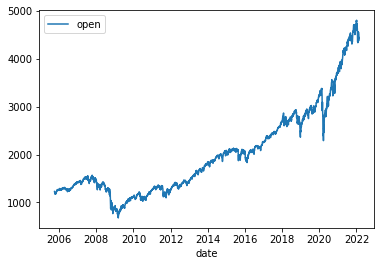

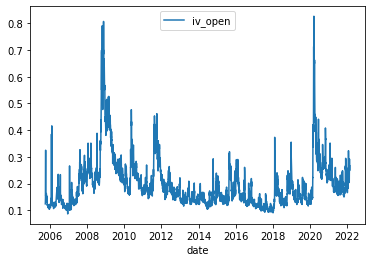

In [74]:
# plot the underlying and iv to visually identify any issues
df.plot('date', 'open')
df.plot('date', 'iv_open')

# below are for 1 min bar size
# df.iloc[:390].plot('date', 'open')
# df.iloc[:390].plot('date', 'iv_open')
# df.iloc[-390:].plot('date', 'open')
# df.iloc[-390:].plot('date', 'iv_open')

In [81]:
# programmatically test for errors, checking for gaps > 5 days.
delta = pd.Timedelta(days=5)
pf = df.copy()
pf['gap'] = (pf['date'] > pf['date'].shift(1) + delta)
idx = pf[pf['gap'] == True].index
print(pf.iloc[idx][['date']])

Empty DataFrame
Columns: [date]
Index: []


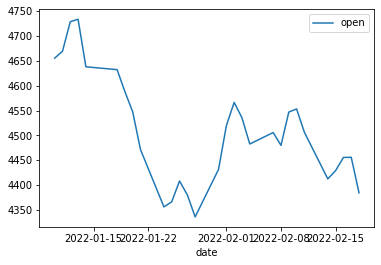

In [78]:
if is_update:
    # ensure no jumps exist where the new df was appended.
    days_missing = int(duration.split(' ')[0])  # turn  string of 'x D' to just grab the int, x.
    df.iloc[-(days_missing+10):].plot('date', 'open')

In [80]:
df.to_pickle(f'../../dfs/{file_name}')
ib.disconnect()  # disconnect from IB
print(f'last saved on {datetime.now().date()}, filename: {file_name}')

last saved on 2022-02-20, filename: 1day_spx_max_iv_rth.pkl
